In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import hddm
from joblib import Parallel, delayed
from IPython import embed as shell

/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set(style='ticks', font='Arial', font_scale=1, rc={
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 6,
    'axes.linewidth': 0.25,
    'xtick.major.width': 0.25,
    'ytick.major.width': 0.25,
    'ytick.major.width': 0.25,
    'ytick.major.width': 0.25,
    'ytick.major.pad' : 2.0,
    'ytick.minor.pad' : 2.0,
    'xtick.major.pad' : 2.0,
    'xtick.minor.pad' : 2.0,
    'axes.labelpad' : 4.0,
    'axes.titlepad' : 6.0,
    } )
sns.plotting_context()

{'font.size': 12.0,
 'axes.labelsize': 7.0,
 'axes.titlesize': 7.0,
 'xtick.labelsize': 6.0,
 'ytick.labelsize': 6.0,
 'legend.fontsize': 6.0,
 'axes.linewidth': 0.25,
 'grid.linewidth': 1.0,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.25,
 'ytick.major.width': 0.25,
 'xtick.minor.width': 1.0,
 'ytick.minor.width': 1.0,
 'xtick.major.size': 6.0,
 'ytick.major.size': 6.0,
 'xtick.minor.size': 4.0,
 'ytick.minor.size': 4.0,
 'legend.title_fontsize': 12.0}

In [3]:
def get_choice(row):
    
    if row.condition == 'present':
        if row.response == 1:
            return 1
        else:
            return 0
    elif row.condition == 'absent':
        if row.response == 0:
            return 1
        else:
            return 0

In [4]:
def simulate_data(a, v, t, z, dc, sv=0, sz=0, st=0, condition=0, nr_trials1=1000, nr_trials2=1000):
    
    """
    Simulates stim-coded data.
    """
    
    parameters1 = {'a':a, 'v':v+dc, 't':t, 'z':z, 'sv':sv, 'sz': sz, 'st': st}
    parameters2 = {'a':a, 'v':v-dc, 't':t, 'z':1-z, 'sv':sv, 'sz': sz, 'st': st}
    df_sim1, params_sim1 = hddm.generate.gen_rand_data(params=parameters1, size=nr_trials1, subjs=1, subj_noise=0)
    df_sim1['condition'] = 'present'
    df_sim2, params_sim2 = hddm.generate.gen_rand_data(params=parameters2, size=nr_trials2, subjs=1, subj_noise=0)
    df_sim2['condition'] = 'absent'
    df_sim = pd.concat((df_sim1, df_sim2))
    df_sim['bias_response'] = df_sim.apply(get_choice, 1)
    df_sim['correct'] = df_sim['response'].astype(int)
    df_sim['response'] = df_sim['bias_response'].astype(int)
    df_sim['stimulus'] = np.array((np.array(df_sim['response']==1) & np.array(df_sim['correct']==1)) + (np.array(df_sim['response']==0) & np.array(df_sim['correct']==0)), dtype=int)
    df_sim['condition'] = condition
    df_sim = df_sim.drop(columns=['bias_response'])
    
    return df_sim

In [5]:
def fit_subject(data, depends_on=None, quantiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]):
    
    """
    Simulates stim-coded data.
    """
    
    subj_idx = np.unique(data['subj_idx'])
    m = hddm.HDDMStimCoding(data, stim_col='stimulus', split_param='v', drift_criterion=True, bias=True, 
                            include=('sv'), depends_on=depends_on, p_outlier=0,)
    m.optimize('gsquare', quantiles=quantiles, n_runs=10)
    res = pd.concat((pd.DataFrame([m.values], index=[subj_idx]), pd.DataFrame([m.bic_info], index=[subj_idx])), axis=1)
    return res

In [6]:
def summary_plot(df_group, df_sim_group=None, quantiles=[0, 0.1, 0.3, 0.5, 0.7, 0.9,], xlim=None):

    # # remove NaNs:
    # df = df.loc[~pd.isna(df.rt),:]
    # if df_sim is not None:
    #     df_sim = df_sim.loc[~pd.isna(df_sim.rt),:]

    nr_subjects = len(np.unique(df_group['subj_idx']))

    fig = plt.figure(figsize=(10,nr_subjects*2))
    plt_nr = 1
    for s in np.unique(df_group['subj_idx']):
        
        print(s)

        df = df_group.copy().loc[(df_group['subj_idx']==s),:]
        df_sim = df_sim_group.copy().loc[(df_sim_group['subj_idx']==s),:]
        df['rt_acc'] = df['rt'].copy()
        df.loc[df['correct']==0, 'rt_acc'] = df.loc[df['correct']==0, 'rt_acc'] * -1
        df['rt_resp'] = df['rt'].copy()
        df.loc[df['response']==0, 'rt_resp'] = df.loc[df['response']==0, 'rt_resp'] * -1
        df_sim['rt_acc'] = df_sim['rt'].copy()
        df_sim.loc[df_sim['correct']==0, 'rt_acc'] = df_sim.loc[df_sim['correct']==0, 'rt_acc'] * -1
        df_sim['rt_resp'] = df_sim['rt'].copy()
        df_sim.loc[df_sim['response']==0, 'rt_resp'] = df_sim.loc[df_sim['response']==0, 'rt_resp'] * -1
        max_rt = np.percentile(df_sim.loc[~np.isnan(df_sim['rt']), 'rt'], 99)
        bins = np.linspace(-max_rt,max_rt,21)
        
        # rt distributions correct vs error:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        N, bins, patches = ax.hist(df.loc[:, 'rt_acc'], bins=bins, 
                                   density=True, color='green', alpha=0.5)       
        for bin_size, bin, patch in zip(N, bins, patches):
            if bin < 0:
                plt.setp(patch, 'facecolor', 'r')
        if df_sim is not None:
            ax.hist(df_sim.loc[:, 'rt_acc'], bins=bins, density=True, 
                    histtype='step', color='k', alpha=1, label=None)   
        ax.set_title('P(correct)={}'.format(round(df.loc[:, 'correct'].mean(), 3),))
        ax.set_xlabel('RT (s)')
        ax.set_ylabel('Trials (prob. dens.)')
        plt_nr += 1

        # condition accuracy plots:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        df.loc[:,'rt_bin'] = pd.qcut(df['rt'], quantiles, labels=False)
        d = df.groupby(['rt_bin']).mean().reset_index()
        ax.errorbar(d.loc[:, "rt"], d.loc[:, "correct"], fmt='-o', color='orange', markersize=10)
        if df_sim is not None:
            df_sim.loc[:,'rt_bin'] = pd.qcut(df_sim['rt'], quantiles, labels=False)
            d = df_sim.groupby(['rt_bin']).mean().reset_index()
            ax.errorbar(d.loc[:, "rt"], d.loc[:, "correct"], fmt='x', color='k', markersize=6)
        if xlim:
            ax.set_xlim(xlim)
        ax.set_ylim(0, 1)
        ax.set_title('Conditional accuracy')
        ax.set_xlabel('RT (quantiles)')
        ax.set_ylabel('P(correct)')
        plt_nr += 1
        
        # rt distributions response 1 vs 0:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        if np.isnan(df['rt']).sum() > 0:
            bar_width = 1
            fraction_yes = df['response'].mean()
            fraction_yes_sim = df_sim['response'].mean()
            hist, edges = np.histogram(df.loc[:, 'rt_resp'], bins=bins, density=True,)
            hist = hist * fraction_yes
            hist_sim, edges_sim = np.histogram(df_sim.loc[:, 'rt_resp'], bins=bins, density=True,)
            hist_sim = hist_sim * fraction_yes_sim
            ax.bar(edges[:-1], hist, width=np.diff(edges)[0], align='edge', 
                   color='magenta', alpha=0.5, linewidth=0,)
            # ax.plot(edges_sim[:-1], hist_sim, color='k', lw=1)
            ax.step(edges_sim[:-1]+np.diff(edges)[0], hist_sim, color='black', lw=1)
            # ax.hist(hist, edges, histtype='stepfilled', color='magenta', alpha=0.5, label='response')
            # ax.hist(hist_sim, edges_sim, histtype='step', color='k',)
            no_height = (1 - fraction_yes) / bar_width 
            no_height_sim = (1 - fraction_yes_sim) / bar_width 
            ax.bar(x=-1.5, height=no_height, width=bar_width, alpha=0.5, color='cyan', align='center')
            ax.hlines(y=no_height_sim, xmin=-2, xmax=-1, lw=0.5, colors='black',)
            ax.vlines(x=-2, ymin=0, ymax=no_height_sim, lw=0.5, colors='black')
            ax.vlines(x=-1, ymin=0, ymax=no_height_sim, lw=0.5, colors='black')
        else:
            N, bins, patches = ax.hist(df.loc[:, 'rt_resp'], bins=bins, 
                                   density=True, color='magenta', alpha=0.5)       
            for bin_size, bin, patch in zip(N, bins, patches):
                if bin < 0:
                    plt.setp(patch, 'facecolor', 'cyan')
            ax.hist(df_sim.loc[:, 'rt_resp'], bins=bins, density=True, 
                    histtype='step', color='k', alpha=1, label=None) 
        ax.set_title('P(bias)={}'.format(round(df.loc[:, 'response'].mean(), 3),))
        ax.set_xlabel('RT (s)')
        ax.set_ylabel('Trials (prob. dens.)')
        plt_nr += 1
        
        # condition response plots:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        df.loc[:,'rt_bin'] = pd.qcut(df['rt'], quantiles, labels=False)
        d = df.groupby(['rt_bin']).mean().reset_index()
        ax.errorbar(d.loc[:, "rt"], d.loc[:, "response"], fmt='-o', color='orange', markersize=10)
        if df_sim is not None:
            df_sim.loc[:,'rt_bin'] = pd.qcut(df_sim['rt'], quantiles, labels=False)
            d = df_sim.groupby(['rt_bin']).mean().reset_index()
            ax.errorbar(d.loc[:, "rt"], d.loc[:, "response"], fmt='x', color='k', markersize=6)
        if xlim:
            ax.set_xlim(xlim)
        ax.set_ylim(0,1)
        ax.set_title('Conditional response')
        ax.set_xlabel('RT (quantiles)')
        ax.set_ylabel('P(bias)')
        plt_nr += 1
        
    sns.despine(offset=3, trim=True)
    plt.tight_layout()

    return fig

In [7]:
# settings
n_subjects = 10
trials_per_level = 1000000/4

# parameters:
params0 = {'cond':0, 'v':1, 'a':1, 't':0.3, 'z':0.5, 'dc':-0.5, 'sz':0, 'st':0, 'sv':0}
params1 = {'cond':1, 'v':1, 'a':1, 't':0.3, 'z':0.5, 'dc':0.0, 'sz':0, 'st':0, 'sv':0}

In [8]:
# simulate:
def simulate(params0, params1, trials_per_level, subj):
    df0 = simulate_data(z=params0['z'], a=params0['a'], v=params0['v'], dc=params0['dc'], 
                    t=params0['t'], sv=params0['sv'], st=params0['st'], sz=params0['sz'], 
                    condition=params0['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df1 = simulate_data(z=params1['z'], a=params1['a'], v=params1['v'], dc=params1['dc'], 
                        t=params1['t'], sv=params1['sv'], st=params1['st'], sz=params1['sz'], 
                        condition=params1['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df = pd.concat((df0, df1))
    df['subj_idx'] = subj
    return df
df_emp = pd.concat(Parallel(n_jobs=n_subjects)(delayed(simulate)(params0, params1, trials_per_level, subj) 
                                                      for subj in range(n_subjects)))

In [9]:
# print:
print(df_emp.head())
print(df_emp['correct'].mean())
print(df_emp.shape)

      rt  response  subj_idx  condition  correct  stimulus
0  0.416         1         0          0        1         1
1  0.474         0         0          0        0         1
2  0.362         1         0          0        1         1
3  0.618         1         0          0        1         1
4  0.607         1         0          0        1         1
0.7253534
(10000000, 6)


In [10]:
# fit chi-square:
params1 = pd.concat(Parallel(n_jobs=n_subjects)(delayed(fit_subject)(data, depends_on={'dc':'condition'}) 
                                                      for subj, data in df_emp.groupby('subj_idx')))
params1.drop(['bic', 'likelihood', 'penalty'], axis=1, inplace=True)
print(params1)

          a         v         t        sv   z_trans         z     dc(0)  \
0  1.000327  1.005121  0.300067  0.013025  0.003514  0.500878 -0.504898   
1  0.999100  0.998912  0.300258  0.000167  0.001505  0.500376 -0.499553   
2  0.999123  0.999344  0.300153  0.053017  0.004274  0.501069 -0.504160   
3  0.999949  0.998704  0.299878  0.000411 -0.003846  0.499039 -0.495586   
4  0.999186  1.000429  0.300243  0.104148 -0.000773  0.499807 -0.499454   
5  0.998992  1.000656  0.300080  0.064545  0.003530  0.500882 -0.507098   
6  1.000181  1.002518  0.299771  0.078549 -0.002992  0.499252 -0.498913   
7  0.999541  1.001546  0.300179  0.000915  0.002484  0.500621 -0.502092   
8  1.000692  1.002241  0.299954  0.076155 -0.002187  0.499453 -0.499333   
9  0.999311  1.004072  0.300610  0.075387 -0.001947  0.499513 -0.502628   

      dc(1)  
0 -0.005197  
1  0.004028  
2 -0.008469  
3  0.006131  
4  0.005275  
5 -0.001725  
6  0.012472  
7 -0.003456  
8  0.006086  
9  0.006178  


In [11]:
# fit chi-square:
params2 = pd.concat(Parallel(n_jobs=n_subjects)(delayed(fit_subject)(data, depends_on=None) 
                                                      for subj, data in df_emp.groupby('subj_idx')))
params2.drop(['bic', 'likelihood', 'penalty',], axis=1, inplace=True)
print(params2)

          a         v         t        sv   z_trans         z        dc
0  0.997470  0.993749  0.300049  0.105345  0.007665  0.501916 -0.265368
1  0.996027  0.988875  0.300255  0.031848  0.009609  0.502402 -0.265364
2  0.999722  1.002287  0.300190  0.317449  0.002439  0.500610 -0.254735
3  0.997686  0.988991  0.299882  0.114206  0.001851  0.500463 -0.253814
4  0.997415  0.987617  0.300051  0.157518  0.001747  0.500437 -0.248031
5  0.997213  0.990058  0.299973  0.155140  0.001150  0.500287 -0.249457
6  1.000396  1.007417  0.299951  0.340091 -0.000089  0.499978 -0.247808
7  0.997878  0.994299  0.300108  0.142959  0.000628  0.500157 -0.246748
8  0.997835  0.986798  0.299968  0.129275 -0.001249  0.499688 -0.247013
9  0.998438  0.993381  0.300169  0.163046 -0.002421  0.499395 -0.242642


In [12]:
sv = pd.concat((params1['sv'], params2['sv']), axis=1)
sv['subj_idx'] = np.arange(n_subjects)
sv = sv.melt(id_vars=['subj_idx'])
sv['model'] = np.concatenate((np.zeros(n_subjects), np.ones(n_subjects)))
print(sv)

    subj_idx variable     value  model
0          0       sv  0.013025    0.0
1          1       sv  0.000167    0.0
2          2       sv  0.053017    0.0
3          3       sv  0.000411    0.0
4          4       sv  0.104148    0.0
5          5       sv  0.064545    0.0
6          6       sv  0.078549    0.0
7          7       sv  0.000915    0.0
8          8       sv  0.076155    0.0
9          9       sv  0.075387    0.0
10         0       sv  0.105345    1.0
11         1       sv  0.031848    1.0
12         2       sv  0.317449    1.0
13         3       sv  0.114206    1.0
14         4       sv  0.157518    1.0
15         5       sv  0.155140    1.0
16         6       sv  0.340091    1.0
17         7       sv  0.142959    1.0
18         8       sv  0.129275    1.0
19         9       sv  0.163046    1.0


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


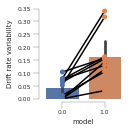

In [13]:
fig = plt.figure(figsize=(2,2))
sns.barplot(x='model', y='value', units='subj_idx', data=sv)
sns.stripplot(x='model', y='value', jitter=False, data=sv)
plt.plot(np.vstack((np.zeros(n_subjects), np.ones(n_subjects))), 
         np.vstack((sv.loc[sv['model']==0,'value'], sv.loc[sv['model']==1,'value'])),
        color='black')
plt.ylabel('Drift rate variability')
sns.despine(offset=3, trim=True)
plt.tight_layout()
fig.savefig('figs/ddm/drift_rate1.pdf')

In [14]:
# settings
n_subjects = 10
trials_per_level = 1000000/4

params = []
dcs = [-1, -0.8, -0.6, -0.4, -0.2, -0]
for dc in dcs:
    
    print(dc)

    # parameters:
    params0 = {'cond':0, 'v':1, 'a':1, 't':0.3, 'z':0.5, 'dc':dc, 'sz':0, 'st':0, 'sv':0}
    params1 = {'cond':1, 'v':1, 'a':1, 't':0.3, 'z':0.5, 'dc':0.0, 'sz':0, 'st':0, 'sv':0}

    # simulate:
    def simulate(params0, params1, trials_per_level, subj):
        df0 = simulate_data(z=params0['z'], a=params0['a'], v=params0['v'], dc=params0['dc'], 
                        t=params0['t'], sv=params0['sv'], st=params0['st'], sz=params0['sz'], 
                        condition=params0['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
        df1 = simulate_data(z=params1['z'], a=params1['a'], v=params1['v'], dc=params1['dc'], 
                            t=params1['t'], sv=params1['sv'], st=params1['st'], sz=params1['sz'], 
                            condition=params1['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
        df = pd.concat((df0, df1))
        df['subj_idx'] = subj
        return df
    df_emp = pd.concat(Parallel(n_jobs=n_subjects)(delayed(simulate)(params0, params1, trials_per_level, subj) 
                                                          for subj in range(n_subjects)))
    
    # fit chi-square:
    pars = pd.concat(Parallel(n_jobs=n_subjects)(delayed(fit_subject)(data, depends_on=None) 
                                                          for subj, data in df_emp.groupby('subj_idx')))
    pars.drop(['bic', 'likelihood', 'penalty',], axis=1, inplace=True)
    pars['magnitude'] = dc
    params.append(pars)

-1
-0.8
-0.6
-0.4
-0.2
0


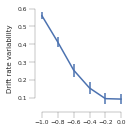

In [15]:
p = pd.concat(params)
fig = plt.figure(figsize=(2,2))
plt.errorbar(x=np.array(dcs), y=np.array(p.groupby('magnitude').mean()['sv']), yerr=np.array(p.groupby('magnitude').sem()['sv']))
plt.ylabel('Drift rate variability')
sns.despine(offset=3, trim=True)
plt.tight_layout()
fig.savefig('figs/ddm/drift_rate2.pdf')